In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on
# Pour vérifier que le code respecte la convention PEP8

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import sys
import sklearn
from datetime import datetime
import time
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

In [4]:
data_maint = pd.read_csv('data.maint.csv')

In [5]:
data_maint['order_purchase_timestamp'] = data_maint[
    'order_purchase_timestamp'].apply(
     lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
                                    )

In [6]:
data_maint = data_maint.set_index('customer_unique_id')
data_maint = data_maint.drop(['customer_state', 'payment_type',
                              'product_category_name'], 1)

In [7]:
colonnes = data_maint.columns.to_list()
colonnes.remove('order_purchase_timestamp')

Pour étudier la stabilité des clusters au cours du temps, on doit calculer l'écart entre un "predict" du modèle initial
et le "fit" d'un nouveau modèle grâce à la fonction Ajusted_Rand_Score de la façon suivante:
adjusted_rand_score(labels_true, labels_pred)

La fonction Ajusted_Rand_Score calcule une mesure de similarité entre deux clusters en considérant toutes les paires d'échantillons et en comptant les paires qui sont assignées dans le même cluster ou dans des clusters différents dans les clusters prédits et réels.

In [8]:
debut_periode, fin_periode = data_maint['order_purchase_timestamp'].min(),\
                             data_maint['order_purchase_timestamp'].max()

In [9]:
debut_periode, fin_periode

(Timestamp('2016-10-03 09:44:50'), Timestamp('2018-08-29 15:00:37'))

## <span style='background:Thistle'>1. Mise à jour par semaine</span>

In [10]:
date_T0_sem = pd.date_range(debut_periode, fin_periode, freq="w")[74]
date_T0_TN_sem = pd.date_range(debut_periode, fin_periode, freq="w")[75:]

On va étudier la stabilité des clusters sur les 5 derniers mois

In [11]:
date_T0_sem

Timestamp('2018-03-11 09:44:50', freq='W-SUN')

In [12]:
date_T0_TN_sem

DatetimeIndex(['2018-03-18 09:44:50', '2018-03-25 09:44:50',
               '2018-04-01 09:44:50', '2018-04-08 09:44:50',
               '2018-04-15 09:44:50', '2018-04-22 09:44:50',
               '2018-04-29 09:44:50', '2018-05-06 09:44:50',
               '2018-05-13 09:44:50', '2018-05-20 09:44:50',
               '2018-05-27 09:44:50', '2018-06-03 09:44:50',
               '2018-06-10 09:44:50', '2018-06-17 09:44:50',
               '2018-06-24 09:44:50', '2018-07-01 09:44:50',
               '2018-07-08 09:44:50', '2018-07-15 09:44:50',
               '2018-07-22 09:44:50', '2018-07-29 09:44:50',
               '2018-08-05 09:44:50', '2018-08-12 09:44:50',
               '2018-08-19 09:44:50', '2018-08-26 09:44:50'],
              dtype='datetime64[ns]', freq='W-SUN')

In [13]:
data_F0 = data_maint[(data_maint['order_purchase_timestamp'] < date_T0_sem)]
data_F0 = data_F0[colonnes].copy()

In [14]:
model_M0 = KMeans(n_clusters=6, init='k-means++',
                  max_iter=300, random_state=42)
scaler_T0 = StandardScaler()
data_F0 = scaler_T0.fit_transform(data_F0)
model_M0.fit(data_F0)

KMeans(n_clusters=6, random_state=42)

In [15]:
ARI_score_sem = []
sem = 0
for date_TI in date_T0_TN_sem:
    data_TI = data_maint[(data_maint['order_purchase_timestamp'] < date_TI)]
    data_TI = data_TI[colonnes].copy()
    sem += 1
    print('nombre de client :', len(data_TI), 'pour la date :',
          date_TI, ' ( T', sem, ')')
    scaler_TI = StandardScaler()
    data_TI_scaled = scaler_TI.fit_transform(data_TI)
    model_MI = KMeans(n_clusters=5, init='k-means++',
                      max_iter=300, random_state=42)
    model_MI.fit(data_TI_scaled)
    ARI_score_sem.append(
        adjusted_rand_score(
            model_MI.predict(data_TI_scaled),
            model_M0.predict(scaler_T0.transform(data_TI))
        )
    )

nombre de client : 62014 pour la date : 2018-03-18 09:44:50  ( T 1 )
nombre de client : 63769 pour la date : 2018-03-25 09:44:50  ( T 2 )
nombre de client : 65215 pour la date : 2018-04-01 09:44:50  ( T 3 )
nombre de client : 66780 pour la date : 2018-04-08 09:44:50  ( T 4 )
nombre de client : 68259 pour la date : 2018-04-15 09:44:50  ( T 5 )
nombre de client : 69965 pour la date : 2018-04-22 09:44:50  ( T 6 )
nombre de client : 71695 pour la date : 2018-04-29 09:44:50  ( T 7 )
nombre de client : 73477 pour la date : 2018-05-06 09:44:50  ( T 8 )
nombre de client : 75481 pour la date : 2018-05-13 09:44:50  ( T 9 )
nombre de client : 77399 pour la date : 2018-05-20 09:44:50  ( T 10 )
nombre de client : 78446 pour la date : 2018-05-27 09:44:50  ( T 11 )
nombre de client : 79437 pour la date : 2018-06-03 09:44:50  ( T 12 )
nombre de client : 80910 pour la date : 2018-06-10 09:44:50  ( T 13 )
nombre de client : 82489 pour la date : 2018-06-17 09:44:50  ( T 14 )
nombre de client : 83941 pour

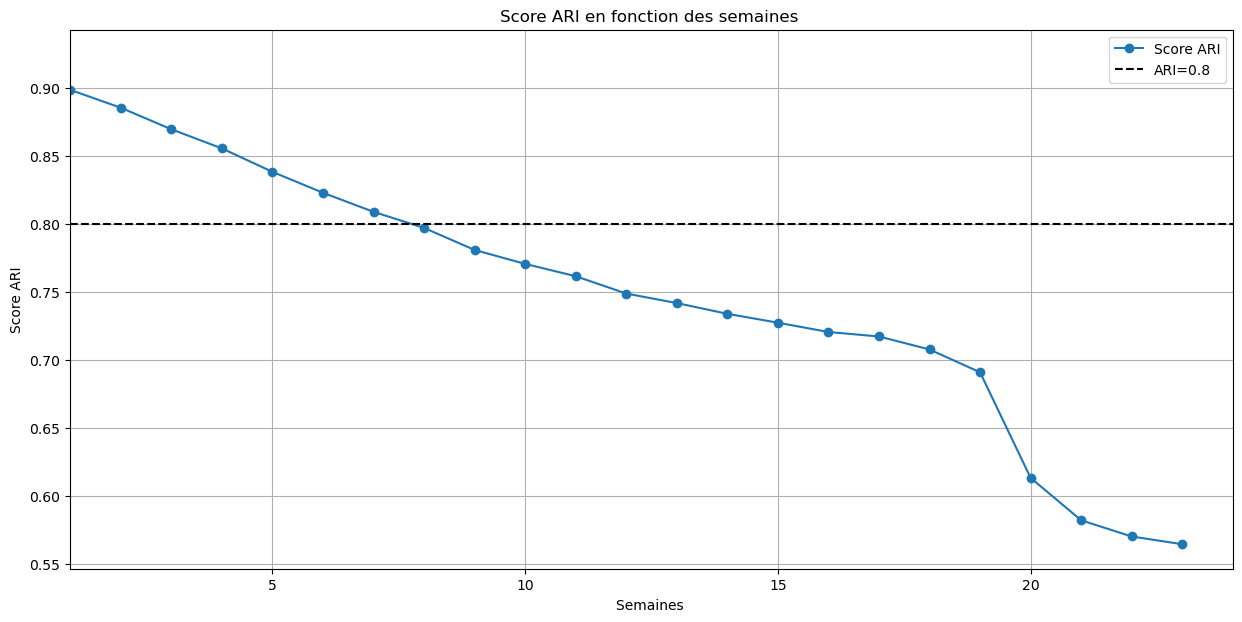

In [16]:
df_ARI = pd.DataFrame({"Semaine": range(0, len(ARI_score_sem)),
                      "Score_ARI": ARI_score_sem})
plt.figure(figsize=(15, 7))
plt.plot(
    "Semaine",
    "Score_ARI",
    data=df_ARI,
    linestyle="-",
    marker="o",
    label="Score ARI",
)
plt.axhline(
    y=0.8,
    linestyle="--",
    color="black",
    label="ARI=0.8",
)
plt.grid()
plt.xlim(1, len(ARI_score_sem))
plt.xlabel("Semaines ")
plt.ylabel("Score ARI")
plt.legend()
plt.title("Score ARI en fonction des semaines ")
plt.show()

Au bout de 8 semaines, le score ARI est inférieur à 0.8. Il faut faire une mise à jour des clients tous les 8 semaines (2 mois).

## <span style='background:Thistle'>2. Mise à jour par mois</span>

In [17]:
date_T0_mois = pd.date_range(debut_periode, fin_periode, freq="M")[8]
date_T0_TN_mois = pd.date_range(debut_periode, fin_periode, freq="M")[9:]

On va étudier la stabilité des clusters sur les 14 derniers mois

In [18]:
date_T0_mois

Timestamp('2017-06-30 09:44:50', freq='M')

In [19]:
date_T0_TN_mois

DatetimeIndex(['2017-07-31 09:44:50', '2017-08-31 09:44:50',
               '2017-09-30 09:44:50', '2017-10-31 09:44:50',
               '2017-11-30 09:44:50', '2017-12-31 09:44:50',
               '2018-01-31 09:44:50', '2018-02-28 09:44:50',
               '2018-03-31 09:44:50', '2018-04-30 09:44:50',
               '2018-05-31 09:44:50', '2018-06-30 09:44:50',
               '2018-07-31 09:44:50'],
              dtype='datetime64[ns]', freq='M')

In [20]:
data_F0_mois = data_maint[(data_maint['order_purchase_timestamp']
                           < date_T0_mois)]
data_F0_mois = data_F0_mois[colonnes].copy()

In [21]:
model_M0 = KMeans(n_clusters=5, init='k-means++',
                  max_iter=300, random_state=42)
scaler_T0 = StandardScaler()
data_F0_mois = scaler_T0.fit_transform(data_F0_mois)
model_M0.fit(data_F0_mois)

KMeans(n_clusters=5, random_state=42)

In [22]:
ARI_score_mois = []
mois = 0
for date_TI in date_T0_TN_mois:
    data_TI = data_maint[(data_maint['order_purchase_timestamp'] < date_TI)]
    data_TI = data_TI[colonnes].copy()
    mois += 1
    print('nombre de client :', len(data_TI), 'pour la date :',
          date_TI, ' ( T', mois, ')')
    scaler_TI = StandardScaler()
    data_TI_scaled = scaler_TI.fit_transform(data_TI)
    model_MI = KMeans(n_clusters=5, init='k-means++',
                      max_iter=300, random_state=42)
    model_MI.fit(data_TI_scaled)
    ARI_score_mois.append(
        adjusted_rand_score(
            model_MI.predict(data_TI_scaled),
            model_M0.predict(scaler_T0.transform(data_TI))
        )
    )

nombre de client : 17939 pour la date : 2017-07-31 09:44:50  ( T 1 )
nombre de client : 22251 pour la date : 2017-08-31 09:44:50  ( T 2 )
nombre de client : 26474 pour la date : 2017-09-30 09:44:50  ( T 3 )
nombre de client : 30995 pour la date : 2017-10-31 09:44:50  ( T 4 )
nombre de client : 38431 pour la date : 2017-11-30 09:44:50  ( T 5 )
nombre de client : 44167 pour la date : 2017-12-31 09:44:50  ( T 6 )
nombre de client : 51094 pour la date : 2018-01-31 09:44:50  ( T 7 )
nombre de client : 57824 pour la date : 2018-02-28 09:44:50  ( T 8 )
nombre de client : 65046 pour la date : 2018-03-31 09:44:50  ( T 9 )
nombre de client : 71896 pour la date : 2018-04-30 09:44:50  ( T 10 )
nombre de client : 78972 pour la date : 2018-05-31 09:44:50  ( T 11 )
nombre de client : 85282 pour la date : 2018-06-30 09:44:50  ( T 12 )
nombre de client : 91321 pour la date : 2018-07-31 09:44:50  ( T 13 )


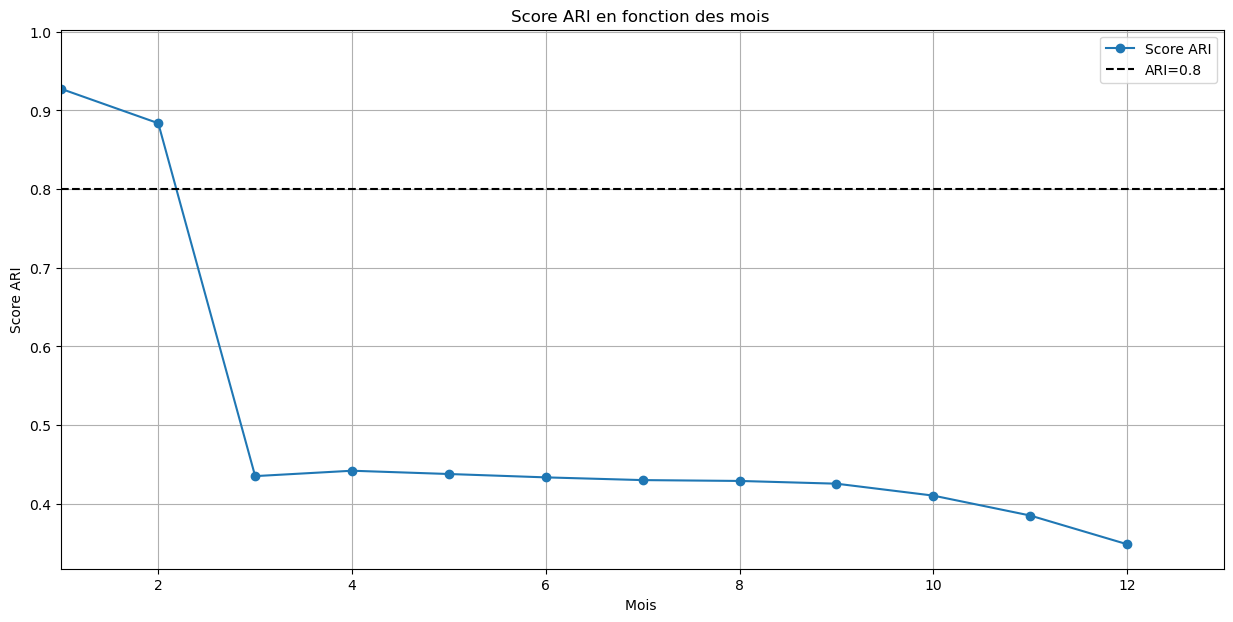

In [23]:
df_ARI_mois = pd.DataFrame({"Mois": range(0, len(ARI_score_mois)),
                           "Score_ARI": ARI_score_mois})
plt.figure(figsize=(15, 7))
plt.plot(
    "Mois",
    "Score_ARI",
    data=df_ARI_mois,
    linestyle="-",
    marker="o",
    label="Score ARI",
)
plt.axhline(
    y=0.8,
    linestyle="--",
    color="black",
    label="ARI=0.8",
)
plt.grid()
plt.xlim(1, len(ARI_score_mois))
plt.xlabel("Mois ")
plt.ylabel("Score ARI")
plt.legend()
plt.title("Score ARI en fonction des mois ")
plt.show()